In [1]:
import tensorflow as tf
import pandas as pd
import argparse
import logging
import io
import os

In [2]:
!pip install tensorflow

In [4]:
!pip install object_detection

     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     -- ------------------------------------- 0.1/1.5 MB 2.2 MB/s eta 0:00:01
     -- ------------------------------------- 0.1/1.5 MB 2.2 MB/s eta 0:00:01
     --- ------------------------------------ 0.1/1.5 MB 944.1 kB/s eta 0:00:02
     ---- ----------------------------------- 0.2/1.5 MB 1.0 MB/s eta 0:00:02
     ------ --------------------------------- 0.3/1.5 MB 1.1 MB/s eta 0:00:02
     --------- ------------------------------ 0.4/1.5 MB 1.3 MB/s eta 0:00:01
     ----------- ---------------------------- 0.4/1.5 MB 1.4 MB/s eta 0:00:01
     ------------ --------------------------- 0.5/1.5 MB 1.4 MB/s eta 0:00:01
     ------------- -------------------------- 0.5/1.5 MB 1.3 MB/s eta 0:00:01
     -------------- ------------------------- 0.5/1.5 MB 1.2 MB/s eta 0:00:01
     

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [5]:
#from PIL import Image
#from object_detection.utils import dataset_util
#from collections import namedtuple, OrderedDict

In [6]:
#logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

In [12]:
class TFRecord:
    def __init__(self, labelmap_file) -> None:
        f = open(labelmap_file, "r")
        labelmap = f.read()
        self.class_names = self.init_names(labelmap)

    def init_names(self, labelmap) -> dict:
        items = labelmap.split('item')[1:]
        items_dict = {}
        for item in items:
            name = str(item.split('name')[1].split('"')[1])
            name_id = int(item.split('name')[1].split('id')[1].\
                                                split(": ")[1].split('}')[0])

            items_dict[name] = name_id
        return items_dict
    
    def class_text_to_int(self, row_label) -> int:
        if self.class_names[row_label] is not None:
            return self.class_names[row_label]
        else:
            None

    def split(self, df, group):
        data = namedtuple('data', ['filename', 'object'])
        gb = df.groupby(group)
        return [data(filename, gb.get_group(x)) for filename, x in \
                                            zip(gb.groups.keys(), gb.groups)]
    
    def create_tf(self, group, path):
        with tf.io.gfile.GFile(os.path.join(path, '{}'\
                                        .format(group.filename)), 'rb') as fid:
            encoded_jpg = fid.read()
        encoded_jpg_io = io.BytesIO(encoded_jpg)
        image = Image.open(encoded_jpg_io)
        width, height = image.size

        filename = group.filename.encode('utf8')
        image_format = b'jpg'
        xmins = []
        xmaxs = []
        ymins = []
        ymaxs = []
        classes_text = []
        classes = []

        for index, row in group.object.iterrows():
            xmins.append(row['xmin'] / width)
            xmaxs.append(row['xmax'] / width)
            ymins.append(row['ymin'] / height)
            ymaxs.append(row['ymax'] / height)
            classes_text.append(row['class'].encode('utf8'))
            classes.append(self.class_text_to_int(row['class']))

        tf_sample = tf.train.Example(features=tf.train.Features(feature={
            'image/height': dataset_util.int64_feature(height),
            'image/width': dataset_util.int64_feature(width),
            'image/filename': dataset_util.bytes_feature(filename),
            'image/source_id': dataset_util.bytes_feature(filename),
            'image/encoded': dataset_util.bytes_feature(encoded_jpg),
            'image/format': dataset_util.bytes_feature(image_format),
            'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
            'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
            'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
            'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
            'image/object/class/text':\
                                dataset_util.bytes_list_feature(classes_text),
            'image/object/class/label':\
                                    dataset_util.int64_list_feature(classes),
        }))
        return tf_sample

    def generate(self, output_path, image_dir, csv_input) -> None:
        writer = tf.io.TFRecordWriter(output_path)
        path = os.path.join(image_dir)
        data = pd.read_csv(csv_input)
        grouped = self.split(data, 'filename')

        for group in grouped:
            try:
              tf_sample = self.create_tf(group, path)
              writer.write(tf_sample.SerializeToString())
            except:
              continue
        logging.info('Successfully created the TFRecords: {}'.format(output_path))

In [342]:
#if __name__ == "__main__":
#    parser = argparse.ArgumentParser(description="Generate tf record")
#    parser.add_argument('-l', '--labelmap',
#                        help = 'Labelmap path',
#                        default = 'labelmap.txt',
#                        dest = 'labelmap_file'
#                        )
#    parser.add_argument('-o', '--output',
#                    help = 'Output path',
#                    default = 'train.record',
#                    dest = 'output_path'
#                    )
#
#    parser.add_argument('-i', '--imagesdir',
#                    help = 'Images directory',
#                    default = 'dataset/images',
#                    dest = 'image_dir'
#                    )
#
#    parser.add_argument('-csv', '--csvinput',
#                    help = 'CSV with images names',
#                    default = 'dataset/labels.csv',
#                    dest = 'csv_input'
#                    )
#    args = parser.parse_args()
#
#    tf_record = TFRecord(args.labelmap_file)
#    tf_record.generate(args.output_path, args.image_dir, args.csv_input)

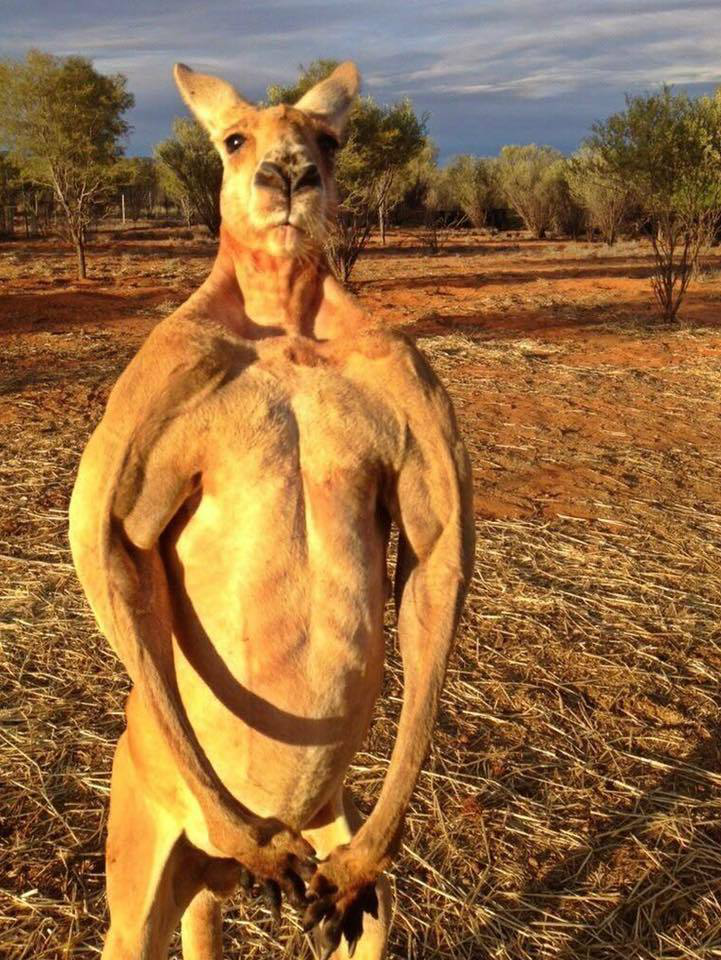

In [5]:
from PIL import Image
im=Image.open('C:/Users/Deepa/Downloads/Kangaroo_Images/kangaroo-6.JPG','r')
im

In [19]:
!pip install fastai

  Obtaining dependency information for fastai from https://files.pythonhosted.org/packages/b4/44/25472496c58a9c4aa43465ae8daffb4452ebbe61b43342fe0f8a53ed836b/fastai-2.7.13-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/67.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/67.6 kB ? eta -:--:--
     ------------------ --------------------- 30.7/67.6 kB ? eta -:--:--
     ----------------------- -------------- 41.0/67.6 kB 960.0 kB/s eta 0:00:01
     ---------------------------------- --- 61.4/67.6 kB 812.7 kB/s eta 0:00:01
     -------------------------------------- 67.6/67.6 kB 610.1 kB/s eta 0:00:00
  Obtaining dependency information for torchvision>=0.11 from https://files.pythonhosted.org/packages/20/ac/ab6f42af83349e679b03c9bb18354740c6b58b17dba329fb408730230584/torchvision-0.16.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for spacy<4 from https://files.pythonhosted.org/packages/90/f0/0133b684e18932c7bf4075d9

In [20]:
from fastai.vision.all import *

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [270]:
data = pd.read_csv("C:/Users/Deepa/Downloads/Pets_Train.csv")
data

,Unnamed: 0,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,...,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,MaxProminence,AvgProminence,MinProminence
0,0,2,Nibble,3,299,0,1,1,7,0,...,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,2,0.499232,0.499232,0.499232
1,1,2,No Name Yet,1,265,0,1,1,2,0,...,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0,0.735349,0.487995,0.240641
2,2,1,Brisco,1,307,0,1,2,7,0,...,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,0,3,0.000000,0.000000,0.000000
3,3,1,Miko,4,307,0,2,1,2,0,...,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,0,2,0.000000,0.000000,0.000000
4,4,1,Hunter,1,307,0,1,1,0,0,...,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,0,2,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,14988,2,NaN,2,266,0,3,1,0,0,...,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,4,2,0.812581,0.282158,0.084041
14989,14989,2,Serato & Eddie,60,265,264,3,1,4,7,...,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3,4,0.647380,0.395720,0.211774
14990,14990,2,Monkies,2,265,266,3,5,6,7,...,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5,3,0.699011,0.541059,0.438720
14991,14991,2,Ms Daym,9,266,0,2,4,7,0,...,41336,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,5,4,0.207249,0.138934,0.091184


In [271]:
import pandas as pd
data2 = pd.read_csv("C:/Users/Deepa/Downloads/ProjectData2_Pets.csv")
data2

,Type,Name,Age,Breed1,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,Tabby,Male,Black,White,NaN,Small,Small,...,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,2
1,2,No Name Yet,1,Domestic Medium Hair,Male,Black,Brown,NaN,Medium,Medium,...,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0
2,1,Brisco,1,Mixed Breed,Male,Brown,White,NaN,Medium,Medium,...,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3
3,1,Miko,4,Mixed Breed,Female,Black,Brown,NaN,Medium,Small,...,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2
4,1,Hunter,1,Mixed Breed,Male,Black,NaN,NaN,Medium,Small,...,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,Domestic Short Hair,Trans,Black,NaN,NaN,Medium,Medium,...,Perfect,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3,2
14989,2,Serato & Eddie,60,Domestic Medium Hair,Trans,Black,Yellow,White,Medium,Medium,...,Perfect,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3,4
14990,2,Monkies,2,Domestic Medium Hair,Trans,Cream,Gray,White,Large,Medium,...,Perfect,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5,3
14991,2,Ms Daym,9,Domestic Short Hair,Female,Yellow,White,NaN,Small,Small,...,Perfect,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3,4


In [272]:
data3 = pd.read_csv("C:/Users/Deepa/Downloads/ProjectData2_Pets.csv")
data3

,Type,Name,Age,Breed1,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,Tabby,Male,Black,White,NaN,Small,Small,...,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,2
1,2,No Name Yet,1,Domestic Medium Hair,Male,Black,Brown,NaN,Medium,Medium,...,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0
2,1,Brisco,1,Mixed Breed,Male,Brown,White,NaN,Medium,Medium,...,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3
3,1,Miko,4,Mixed Breed,Female,Black,Brown,NaN,Medium,Small,...,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2
4,1,Hunter,1,Mixed Breed,Male,Black,NaN,NaN,Medium,Small,...,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,Domestic Short Hair,Trans,Black,NaN,NaN,Medium,Medium,...,Perfect,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3,2
14989,2,Serato & Eddie,60,Domestic Medium Hair,Trans,Black,Yellow,White,Medium,Medium,...,Perfect,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3,4
14990,2,Monkies,2,Domestic Medium Hair,Trans,Cream,Gray,White,Large,Medium,...,Perfect,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5,3
14991,2,Ms Daym,9,Domestic Short Hair,Female,Yellow,White,NaN,Small,Small,...,Perfect,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3,4


In [273]:
data3.pop('Color2')

0         White
1         Brown
2         White
3         Brown
4           NaN
          ...  
14988       NaN
14989    Yellow
14990      Gray
14991     White
14992       NaN
Name: Color2, Length: 14993, dtype: object

In [274]:
data3.pop('Color3')

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
14988      NaN
14989    White
14990    White
14991      NaN
14992      NaN
Name: Color3, Length: 14993, dtype: object

In [275]:
title_mapping1 = {"Black": 1, "Brown": 2, "Golden": 3, "Yellow": 4, "Cream": 5, "Gray": 6, "White": 7}

data3['Color1'] = data3['Color1'].map(title_mapping1)
data3['Color1'] = data3['Color1'].fillna(0)

In [276]:
data3

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,Tabby,Male,1,Small,Small,N,N,...,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,2
1,2,No Name Yet,1,Domestic Medium Hair,Male,1,Medium,Medium,Maybe,Maybe,...,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0
2,1,Brisco,1,Mixed Breed,Male,2,Medium,Medium,Y,Y,...,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3
3,1,Miko,4,Mixed Breed,Female,1,Medium,Small,Y,Y,...,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2
4,1,Hunter,1,Mixed Breed,Male,1,Medium,Small,N,N,...,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,Domestic Short Hair,Trans,1,Medium,Medium,N,N,...,Perfect,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3,2
14989,2,Serato & Eddie,60,Domestic Medium Hair,Trans,1,Medium,Medium,Y,Y,...,Perfect,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3,4
14990,2,Monkies,2,Domestic Medium Hair,Trans,5,Large,Medium,N,Y,...,Perfect,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5,3
14991,2,Ms Daym,9,Domestic Short Hair,Female,4,Small,Small,Y,Y,...,Perfect,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3,4


In [277]:
title_mapping2 = {"Male": 1, "Female": 2, "Trans": 3}
data3['Gender'] = data3['Gender'].map(title_mapping2)

In [278]:
data3

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,Tabby,1,1,Small,Small,N,N,...,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,2
1,2,No Name Yet,1,Domestic Medium Hair,1,1,Medium,Medium,Maybe,Maybe,...,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0
2,1,Brisco,1,Mixed Breed,1,2,Medium,Medium,Y,Y,...,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3
3,1,Miko,4,Mixed Breed,2,1,Medium,Small,Y,Y,...,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2
4,1,Hunter,1,Mixed Breed,1,1,Medium,Small,N,N,...,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,Domestic Short Hair,3,1,Medium,Medium,N,N,...,Perfect,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3,2
14989,2,Serato & Eddie,60,Domestic Medium Hair,3,1,Medium,Medium,Y,Y,...,Perfect,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3,4
14990,2,Monkies,2,Domestic Medium Hair,3,5,Large,Medium,N,Y,...,Perfect,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5,3
14991,2,Ms Daym,9,Domestic Short Hair,2,4,Small,Small,Y,Y,...,Perfect,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3,4


In [279]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [280]:
data3['Breed1'] = le.fit_transform(data3['Breed1'])
data3.head()

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,156,1,1,Small,Small,N,N,...,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,2
1,2,No Name Yet,1,57,1,1,Medium,Medium,Maybe,Maybe,...,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0
2,1,Brisco,1,104,1,2,Medium,Medium,Y,Y,...,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3
3,1,Miko,4,104,2,1,Medium,Small,Y,Y,...,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2
4,1,Hunter,1,104,1,1,Medium,Small,N,N,...,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2


In [281]:
title_mapping3 = {"Small": 1, "Medium": 2, "Large": 3, "Giant": 4}
data3['MaturitySize'] = data3['MaturitySize'].map(title_mapping3)
data3

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,156,1,1,1,Small,N,N,...,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1,2
1,2,No Name Yet,1,57,1,1,2,Medium,Maybe,Maybe,...,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0
2,1,Brisco,1,104,1,2,2,Medium,Y,Y,...,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3
3,1,Miko,4,104,2,1,2,Small,Y,Y,...,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8,2
4,1,Hunter,1,104,1,1,2,Small,N,N,...,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,58,3,1,2,Medium,N,N,...,Perfect,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3,2
14989,2,Serato & Eddie,60,57,3,1,2,Medium,Y,Y,...,Perfect,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3,4
14990,2,Monkies,2,57,3,5,3,Medium,N,Y,...,Perfect,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5,3
14991,2,Ms Daym,9,58,2,4,1,Small,Y,Y,...,Perfect,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3,4


In [282]:
data3.pop('Description')

0        Nibble is a 3+ month old ball of cuteness. He ...
1        I just found it alone yesterday near my apartm...
2        Their pregnant mother was dumped by her irresp...
3        Good guard dog, very alert, active, obedience ...
4        This handsome yet cute boy is up for adoption....
                               ...                        
14988    I have 4 kittens that need to be adopt urgentl...
14989    Serato(female cat- 3 color) is 4 years old and...
14990    Mix breed, good temperament kittens. Love huma...
14991    she is very shy..adventures and independent..s...
14992    Fili just loves laying around and also loves b...
Name: Description, Length: 14993, dtype: object

In [283]:
title_mapping4 = {"Small": 1, "Medium": 2, "Large": 3}
data3['FurLength'] = data3['FurLength'].map(title_mapping4)
data3

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,156,1,1,1,1,N,N,N,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1,2
1,2,No Name Yet,1,57,1,1,2,2,Maybe,Maybe,Maybe,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2,0
2,1,Brisco,1,104,1,2,2,2,Y,Y,N,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7,3
3,1,Miko,4,104,2,1,2,1,Y,Y,N,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8,2
4,1,Hunter,1,104,1,1,2,1,N,N,N,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,58,3,1,2,2,N,N,N,Perfect,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,dc0935a84,3,2
14989,2,Serato & Eddie,60,57,3,1,2,2,Y,Y,Y,Perfect,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,a01ab5b30,3,4
14990,2,Monkies,2,57,3,5,3,2,N,Y,Maybe,Perfect,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,d981b6395,5,3
14991,2,Ms Daym,9,58,2,4,1,1,Y,Y,Y,Perfect,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,e4da1c9e4,3,4


In [284]:
title_mapping5 = {"Y": 1, "N": 2, "Maybe": 3}
data3['Vaccinated'] = data3['Vaccinated'].map(title_mapping5)
data3

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,156,1,1,1,1,2,N,N,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1,2
1,2,No Name Yet,1,57,1,1,2,2,3,Maybe,Maybe,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2,0
2,1,Brisco,1,104,1,2,2,2,1,Y,N,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7,3
3,1,Miko,4,104,2,1,2,1,1,Y,N,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8,2
4,1,Hunter,1,104,1,1,2,1,2,N,N,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,58,3,1,2,2,2,N,N,Perfect,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,dc0935a84,3,2
14989,2,Serato & Eddie,60,57,3,1,2,2,1,Y,Y,Perfect,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,a01ab5b30,3,4
14990,2,Monkies,2,57,3,5,3,2,2,Y,Maybe,Perfect,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,d981b6395,5,3
14991,2,Ms Daym,9,58,2,4,1,1,1,Y,Y,Perfect,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,e4da1c9e4,3,4


In [285]:
title_mapping6 = {"Y": 1, "N": 2, "Maybe": 3}
data3['Dewormed'] = data3['Dewormed'].map(title_mapping6)
data3

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,156,1,1,1,1,2,2,N,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1,2
1,2,No Name Yet,1,57,1,1,2,2,3,3,Maybe,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2,0
2,1,Brisco,1,104,1,2,2,2,1,1,N,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7,3
3,1,Miko,4,104,2,1,2,1,1,1,N,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8,2
4,1,Hunter,1,104,1,1,2,1,2,2,N,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,58,3,1,2,2,2,2,N,Perfect,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,dc0935a84,3,2
14989,2,Serato & Eddie,60,57,3,1,2,2,1,1,Y,Perfect,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,a01ab5b30,3,4
14990,2,Monkies,2,57,3,5,3,2,2,1,Maybe,Perfect,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,d981b6395,5,3
14991,2,Ms Daym,9,58,2,4,1,1,1,1,Y,Perfect,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,e4da1c9e4,3,4


In [286]:
title_mapping7 = {"Y": 1, "N": 2, "Maybe": 3}
data3['Sterilized'] = data3['Sterilized'].map(title_mapping7)
data3

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,156,1,1,1,1,2,2,2,Perfect,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1,2
1,2,No Name Yet,1,57,1,1,2,2,3,3,3,Perfect,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2,0
2,1,Brisco,1,104,1,2,2,2,1,1,2,Perfect,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7,3
3,1,Miko,4,104,2,1,2,1,1,1,2,Perfect,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8,2
4,1,Hunter,1,104,1,1,2,1,2,2,2,Perfect,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,58,3,1,2,2,2,2,2,Perfect,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,dc0935a84,3,2
14989,2,Serato & Eddie,60,57,3,1,2,2,1,1,1,Perfect,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,a01ab5b30,3,4
14990,2,Monkies,2,57,3,5,3,2,2,1,3,Perfect,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,d981b6395,5,3
14991,2,Ms Daym,9,58,2,4,1,1,1,1,1,Perfect,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,e4da1c9e4,3,4


In [287]:
title_mapping8 = {"Perfect": 1, "fine": 2, "Sick": 3}
data3['Health'] = data3['Health'].map(title_mapping8)
data3

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,156,1,1,1,1,2,2,2,1,1,100,Selangor,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1,2
1,2,No Name Yet,1,57,1,1,2,2,3,3,3,1,1,0,Kuala Lumpur,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2,0
2,1,Brisco,1,104,1,2,2,2,1,1,2,1,1,0,Selangor,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7,3
3,1,Miko,4,104,2,1,2,1,1,1,2,1,1,150,Kuala Lumpur,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8,2
4,1,Hunter,1,104,1,1,2,1,2,2,2,1,1,0,Selangor,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,58,3,1,2,2,2,2,2,1,4,0,Selangor,61c84bd7bcb6fb31d2d480b1bcf9682e,0,dc0935a84,3,2
14989,2,Serato & Eddie,60,57,3,1,2,2,1,1,1,1,2,0,Selangor,1d5096c4a5e159a3b750c5cfcf6ceabf,0,a01ab5b30,3,4
14990,2,Monkies,2,57,3,5,3,2,2,1,3,1,5,30,Selangor,6f40a7acfad5cc0bb3e44591ea446c05,0,d981b6395,5,3
14991,2,Ms Daym,9,58,2,4,1,1,1,1,1,1,1,0,Johor,c311c0c569245baa147d91fa4e351ae4,0,e4da1c9e4,3,4


In [288]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data3['State'] = le.fit_transform(data3['State'])
data3.head()

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,156,1,1,1,1,2,2,2,1,1,100,12,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1,2
1,2,No Name Yet,1,57,1,1,2,2,3,3,3,1,1,0,3,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2,0
2,1,Brisco,1,104,1,2,2,2,1,1,2,1,1,0,12,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7,3
3,1,Miko,4,104,2,1,2,1,1,1,2,1,1,150,3,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8,2
4,1,Hunter,1,104,1,1,2,1,2,2,2,1,1,0,12,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3,2


In [289]:
data3.drop_duplicates()

,Type,Name,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,156,1,1,1,1,2,2,2,1,1,100,12,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1,2
1,2,No Name Yet,1,57,1,1,2,2,3,3,3,1,1,0,3,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2,0
2,1,Brisco,1,104,1,2,2,2,1,1,2,1,1,0,12,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7,3
3,1,Miko,4,104,2,1,2,1,1,1,2,1,1,150,3,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8,2
4,1,Hunter,1,104,1,1,2,1,2,2,2,1,1,0,12,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,58,3,1,2,2,2,2,2,1,4,0,12,61c84bd7bcb6fb31d2d480b1bcf9682e,0,dc0935a84,3,2
14989,2,Serato & Eddie,60,57,3,1,2,2,1,1,1,1,2,0,12,1d5096c4a5e159a3b750c5cfcf6ceabf,0,a01ab5b30,3,4
14990,2,Monkies,2,57,3,5,3,2,2,1,3,1,5,30,12,6f40a7acfad5cc0bb3e44591ea446c05,0,d981b6395,5,3
14991,2,Ms Daym,9,58,2,4,1,1,1,1,1,1,1,0,0,c311c0c569245baa147d91fa4e351ae4,0,e4da1c9e4,3,4


In [290]:
data3.pop('Name')

0                Nibble
1           No Name Yet
2                Brisco
3                  Miko
4                Hunter
              ...      
14988               NaN
14989    Serato & Eddie
14990           Monkies
14991           Ms Daym
14992              Fili
Name: Name, Length: 14993, dtype: object

In [291]:
data3

,Type,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,3,156,1,1,1,1,2,2,2,1,1,100,12,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1,2
1,2,1,57,1,1,2,2,3,3,3,1,1,0,3,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2,0
2,1,1,104,1,2,2,2,1,1,2,1,1,0,12,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7,3
3,1,4,104,2,1,2,1,1,1,2,1,1,150,3,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8,2
4,1,1,104,1,1,2,1,2,2,2,1,1,0,12,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,2,58,3,1,2,2,2,2,2,1,4,0,12,61c84bd7bcb6fb31d2d480b1bcf9682e,0,dc0935a84,3,2
14989,2,60,57,3,1,2,2,1,1,1,1,2,0,12,1d5096c4a5e159a3b750c5cfcf6ceabf,0,a01ab5b30,3,4
14990,2,2,57,3,5,3,2,2,1,3,1,5,30,12,6f40a7acfad5cc0bb3e44591ea446c05,0,d981b6395,5,3
14991,2,9,58,2,4,1,1,1,1,1,1,1,0,0,c311c0c569245baa147d91fa4e351ae4,0,e4da1c9e4,3,4


In [292]:
data3.set_index(['RescuerID', 'PetID'])

,,Type,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
RescuerID,PetID,,,,,,,,,,,,,,,,,
8480853f516546f6cf33aa88cd76c379,86e1089a3,2,3,156,1,1,1,1,2,2,2,1,1,100,12,0,1,2
3082c7125d8fb66f7dd4bff4192c8b14,6296e909a,2,1,57,1,1,2,2,3,3,3,1,1,0,3,0,2,0
fa90fa5b1ee11c86938398b60abc32cb,3422e4906,1,1,104,1,2,2,2,1,1,2,1,1,0,12,0,7,3
9238e4f44c71a75282e62f7136c6b240,5842f1ff5,1,4,104,2,1,2,1,1,1,2,1,1,150,3,0,8,2
95481e953f8aed9ec3d16fc4509537e8,850a43f90,1,1,104,1,1,2,1,2,2,2,1,1,0,12,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61c84bd7bcb6fb31d2d480b1bcf9682e,dc0935a84,2,2,58,3,1,2,2,2,2,2,1,4,0,12,0,3,2
1d5096c4a5e159a3b750c5cfcf6ceabf,a01ab5b30,2,60,57,3,1,2,2,1,1,1,1,2,0,12,0,3,4
6f40a7acfad5cc0bb3e44591ea446c05,d981b6395,2,2,57,3,5,3,2,2,1,3,1,5,30,12,0,5,3


In [293]:
data3.pop('RescuerID')

0        8480853f516546f6cf33aa88cd76c379
1        3082c7125d8fb66f7dd4bff4192c8b14
2        fa90fa5b1ee11c86938398b60abc32cb
3        9238e4f44c71a75282e62f7136c6b240
4        95481e953f8aed9ec3d16fc4509537e8
                       ...               
14988    61c84bd7bcb6fb31d2d480b1bcf9682e
14989    1d5096c4a5e159a3b750c5cfcf6ceabf
14990    6f40a7acfad5cc0bb3e44591ea446c05
14991    c311c0c569245baa147d91fa4e351ae4
14992    9ed1d5493d223eaa5024c1a031dbc9c2
Name: RescuerID, Length: 14993, dtype: object

In [294]:
data3.pop('PetID')

0        86e1089a3
1        6296e909a
2        3422e4906
3        5842f1ff5
4        850a43f90
           ...    
14988    dc0935a84
14989    a01ab5b30
14990    d981b6395
14991    e4da1c9e4
14992    a83d95ead
Name: PetID, Length: 14993, dtype: object

In [295]:
data3.pop('VideoAmt')
data3.pop('PhotoAmt')

0        1
1        2
2        7
3        8
4        3
        ..
14988    3
14989    3
14990    5
14991    3
14992    1
Name: PhotoAmt, Length: 14993, dtype: int64

In [296]:
data3

,Type,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed
0,2,3,156,1,1,1,1,2,2,2,1,1,100,12,2
1,2,1,57,1,1,2,2,3,3,3,1,1,0,3,0
2,1,1,104,1,2,2,2,1,1,2,1,1,0,12,3
3,1,4,104,2,1,2,1,1,1,2,1,1,150,3,2
4,1,1,104,1,1,2,1,2,2,2,1,1,0,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,2,58,3,1,2,2,2,2,2,1,4,0,12,2
14989,2,60,57,3,1,2,2,1,1,1,1,2,0,12,4
14990,2,2,57,3,5,3,2,2,1,3,1,5,30,12,3
14991,2,9,58,2,4,1,1,1,1,1,1,1,0,0,4


In [297]:
data3.pop('Type')

0        2
1        2
2        1
3        1
4        1
        ..
14988    2
14989    2
14990    2
14991    2
14992    1
Name: Type, Length: 14993, dtype: int64

In [298]:
data3

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed
0,3,156,1,1,1,1,2,2,2,1,1,100,12,2
1,1,57,1,1,2,2,3,3,3,1,1,0,3,0
2,1,104,1,2,2,2,1,1,2,1,1,0,12,3
3,4,104,2,1,2,1,1,1,2,1,1,150,3,2
4,1,104,1,1,2,1,2,2,2,1,1,0,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,58,3,1,2,2,2,2,2,1,4,0,12,2
14989,60,57,3,1,2,2,1,1,1,1,2,0,12,4
14990,2,57,3,5,3,2,2,1,3,1,5,30,12,3
14991,9,58,2,4,1,1,1,1,1,1,1,0,0,4


In [299]:
data3 = data3.reset_index(drop=True)

In [300]:
data3

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed
0,3,156,1,1,1,1,2,2,2,1,1,100,12,2
1,1,57,1,1,2,2,3,3,3,1,1,0,3,0
2,1,104,1,2,2,2,1,1,2,1,1,0,12,3
3,4,104,2,1,2,1,1,1,2,1,1,150,3,2
4,1,104,1,1,2,1,2,2,2,1,1,0,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,58,3,1,2,2,2,2,2,1,4,0,12,2
14989,60,57,3,1,2,2,1,1,1,1,2,0,12,4
14990,2,57,3,5,3,2,2,1,3,1,5,30,12,3
14991,9,58,2,4,1,1,1,1,1,1,1,0,0,4


In [301]:
data3.to_csv('C:/Users/Deepa/Downloads/datatoSPSS.csv')

In [302]:
#Import needed resource

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [303]:
data3.corr()

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed
Age,1.000000,0.085525,-0.123423,0.090378,0.093673,0.153092,-0.136061,-0.053360,-0.189450,0.103215,-0.113076,0.089168,-0.019845,0.100510
Breed1,0.085525,1.000000,-0.043573,-0.002662,0.059968,0.067901,-0.054354,-0.026220,-0.011775,0.001525,-0.024373,0.047393,0.049225,0.028413
Gender,-0.123423,-0.043573,1.000000,-0.115351,-0.091819,-0.030404,0.078702,0.091431,0.040645,-0.045177,0.494489,-0.050491,-0.017129,0.057622
Color1,0.090378,-0.002662,-0.115351,1.000000,-0.029468,0.066967,-0.017475,-0.019318,-0.037050,0.024410,-0.116688,0.054180,-0.024826,-0.044192
MaturitySize,0.093673,0.059968,-0.091819,-0.029468,1.000000,0.095142,-0.087722,-0.067352,-0.066321,-0.012957,-0.042832,0.041144,0.053451,0.045653
FurLength,0.153092,0.067901,-0.030404,0.066967,0.095142,1.000000,-0.006010,0.016463,0.032092,0.028096,-0.038388,0.159693,0.023398,-0.091337
Vaccinated,-0.136061,-0.054354,0.078702,-0.017475,-0.087722,-0.006010,1.000000,0.722596,0.471204,0.078893,0.125287,-0.121868,-0.055708,-0.059043
Dewormed,-0.053360,-0.026220,0.091431,-0.019318,-0.067352,0.016463,0.722596,1.000000,0.426256,0.072188,0.141355,-0.105978,-0.032471,-0.013210
Sterilized,-0.189450,-0.011775,0.040645,-0.037050,-0.066321,0.032092,0.471204,0.426256,1.000000,0.057916,0.101919,-0.063790,-0.031890,-0.083447
Health,0.103215,0.001525,-0.045177,0.024410,-0.012957,0.028096,0.078893,0.072188,0.057916,1.000000,-0.034567,-0.010073,-0.030066,0.029382


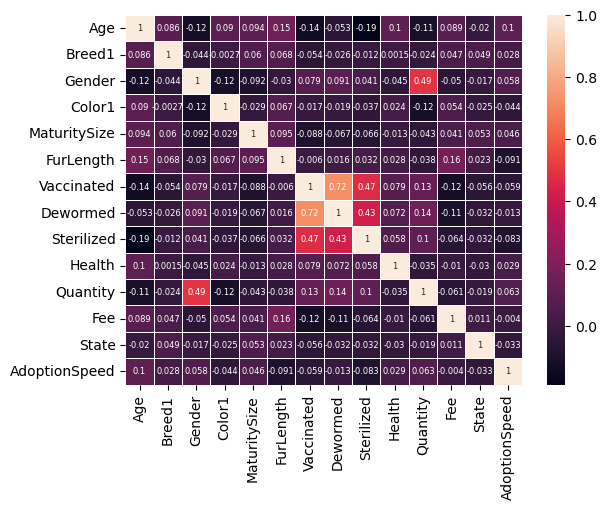

In [304]:
dataplot = sns.heatmap(data3.corr(), annot=True, annot_kws={'size': 6}, linewidth=.4)
plt.show()

In [305]:
x = data3[['Age','Breed1','Gender','Color1','MaturitySize','FurLength', 'Vaccinated','Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State']]
y = data3[['AdoptionSpeed']]

In [306]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.21, random_state = 2406)

In [307]:
x_train

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State
6376,2,104,2,2,2,1,2,1,2,1,1,0,12
1837,41,62,2,2,2,2,1,1,2,1,1,200,12
9354,20,144,2,1,2,2,1,1,1,1,1,0,12
2260,1,58,2,4,2,1,2,2,2,1,1,0,1
8539,2,104,1,1,2,1,2,2,2,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836,12,104,3,1,3,2,2,2,2,1,6,20,12
5598,2,104,1,5,2,1,1,1,3,1,2,0,9
7460,1,57,1,4,2,2,2,2,2,1,1,0,12
4798,4,100,3,1,2,1,2,2,2,1,3,0,12


In [308]:
x_test

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State
2944,2,104,2,2,2,1,1,1,2,1,1,0,12
10290,2,158,2,1,1,2,3,3,3,1,1,0,0
11165,7,104,2,7,2,2,1,1,1,1,1,200,12
6685,2,58,3,1,2,1,2,2,3,1,4,0,13
2926,3,162,1,1,2,2,2,1,2,1,1,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8321,6,104,1,6,2,1,3,3,3,1,1,0,8
11328,85,94,1,5,2,1,1,1,2,1,1,0,12
12699,18,51,2,1,1,3,3,3,2,1,1,0,0
6814,2,104,1,5,2,2,2,1,2,1,1,0,9


In [309]:
headers = x.columns

In [310]:
from sklearn.preprocessing import StandardScaler
st_scale = StandardScaler()


## transforming "train_x"
x_train = st_scale.fit_transform(x_train)
## transforming "test_x"
x_test = st_scale.transform(x_test)
pd.DataFrame(x_train,columns=headers).head()

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State
0,-0.464450,0.504933,0.328732,-0.133880,0.252061,-0.779630,0.397427,-0.807060,0.150711,-0.182808,-0.393232,-0.265039,0.772857
1,1.693737,-0.775013,0.328732,-0.133880,0.252061,0.891369,-1.102135,-0.807060,0.150711,-0.182808,-0.393232,2.231090,0.772857
2,0.531636,1.723929,0.328732,-0.707569,0.252061,0.891369,-1.102135,-0.807060,-1.616638,-0.182808,-0.393232,-0.265039,0.772857
3,-0.519788,-0.896913,0.328732,1.013498,0.252061,-0.779630,0.397427,0.627337,0.150711,-0.182808,-0.393232,-0.265039,-1.817930
4,-0.464450,0.504933,-1.141069,-0.707569,0.252061,-0.779630,0.397427,0.627337,0.150711,-0.182808,-0.393232,-0.265039,-1.346877


In [311]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
acc_log = round(logreg.score(x_train, y_train) * 100, 2)
acc_log

C:\Users\Deepa\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


33.26

In [312]:
coeff_df = pd.DataFrame(x.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
5,FurLength,0.268933
8,Sterilized,0.070706
3,Color1,0.051595
7,Dewormed,0.046716
9,Health,0.007952
1,Breed1,0.006825
6,Vaccinated,-0.031703
0,Age,-0.037256
2,Gender,-0.057686
10,Quantity,-0.059972


In [313]:
data3

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed
0,3,156,1,1,1,1,2,2,2,1,1,100,12,2
1,1,57,1,1,2,2,3,3,3,1,1,0,3,0
2,1,104,1,2,2,2,1,1,2,1,1,0,12,3
3,4,104,2,1,2,1,1,1,2,1,1,150,3,2
4,1,104,1,1,2,1,2,2,2,1,1,0,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,58,3,1,2,2,2,2,2,1,4,0,12,2
14989,60,57,3,1,2,2,1,1,1,1,2,0,12,4
14990,2,57,3,5,3,2,2,1,3,1,5,30,12,3
14991,9,58,2,4,1,1,1,1,1,1,1,0,0,4


In [314]:
x_train = pd.DataFrame(x_train, columns = ['Age','Breed1','Gender','MaturitySize','FurLength', 'Vaccinated', 'Dewormed','Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'AdoptionSpeed'])
x_test = pd.DataFrame(x_test, columns = ['Age','Breed1','Gender','MaturitySize','FurLength', 'Vaccinated', 'Dewormed','Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'AdoptionSpeed'])

<Axes: >

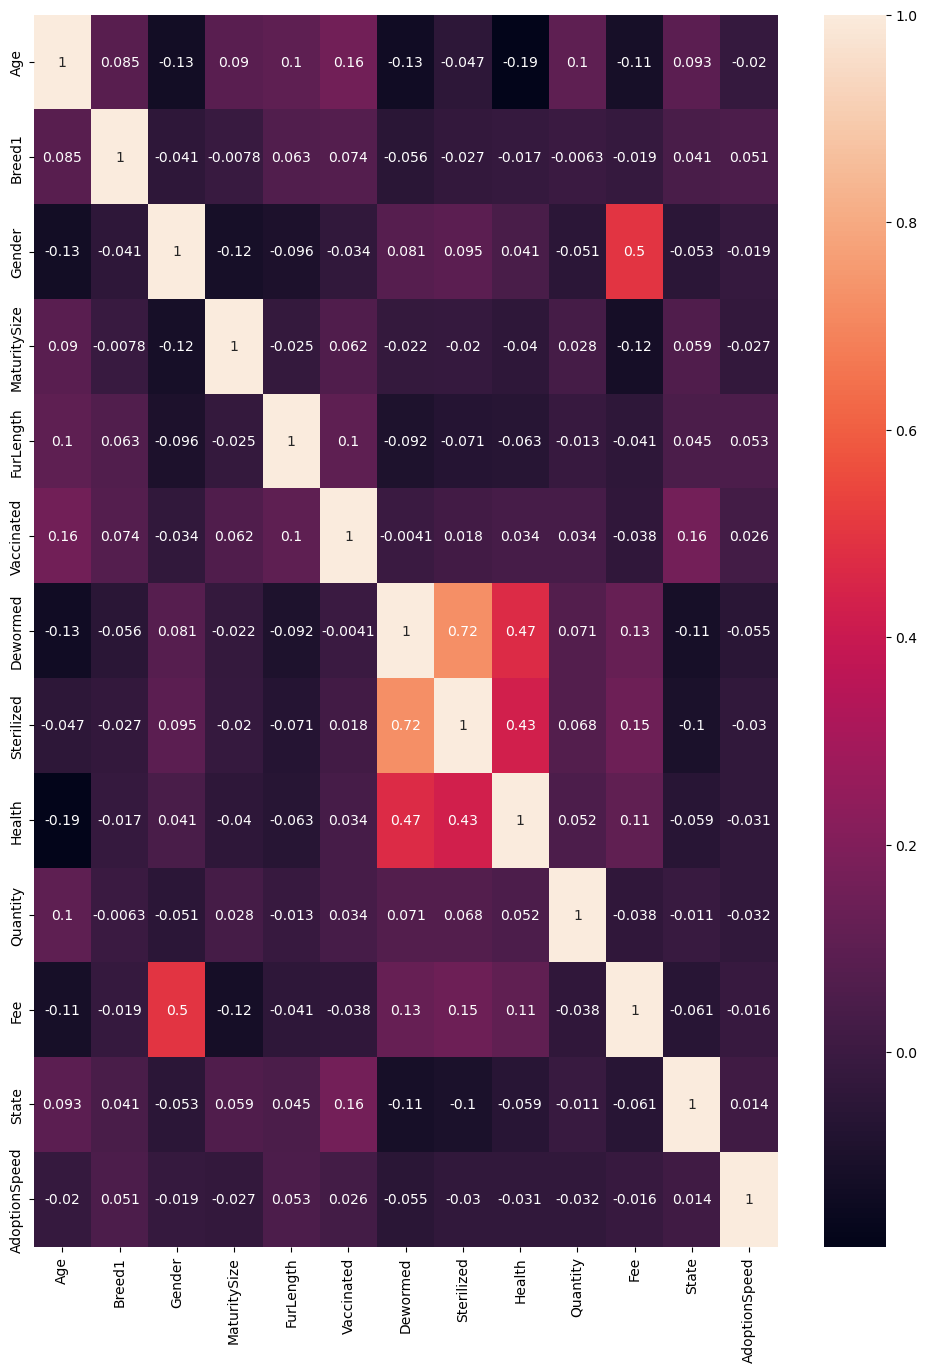

In [315]:
plt.figure(figsize=(12,16))
corr= x_train.corr()
sns.heatmap(corr, annot=True)

<Axes: >

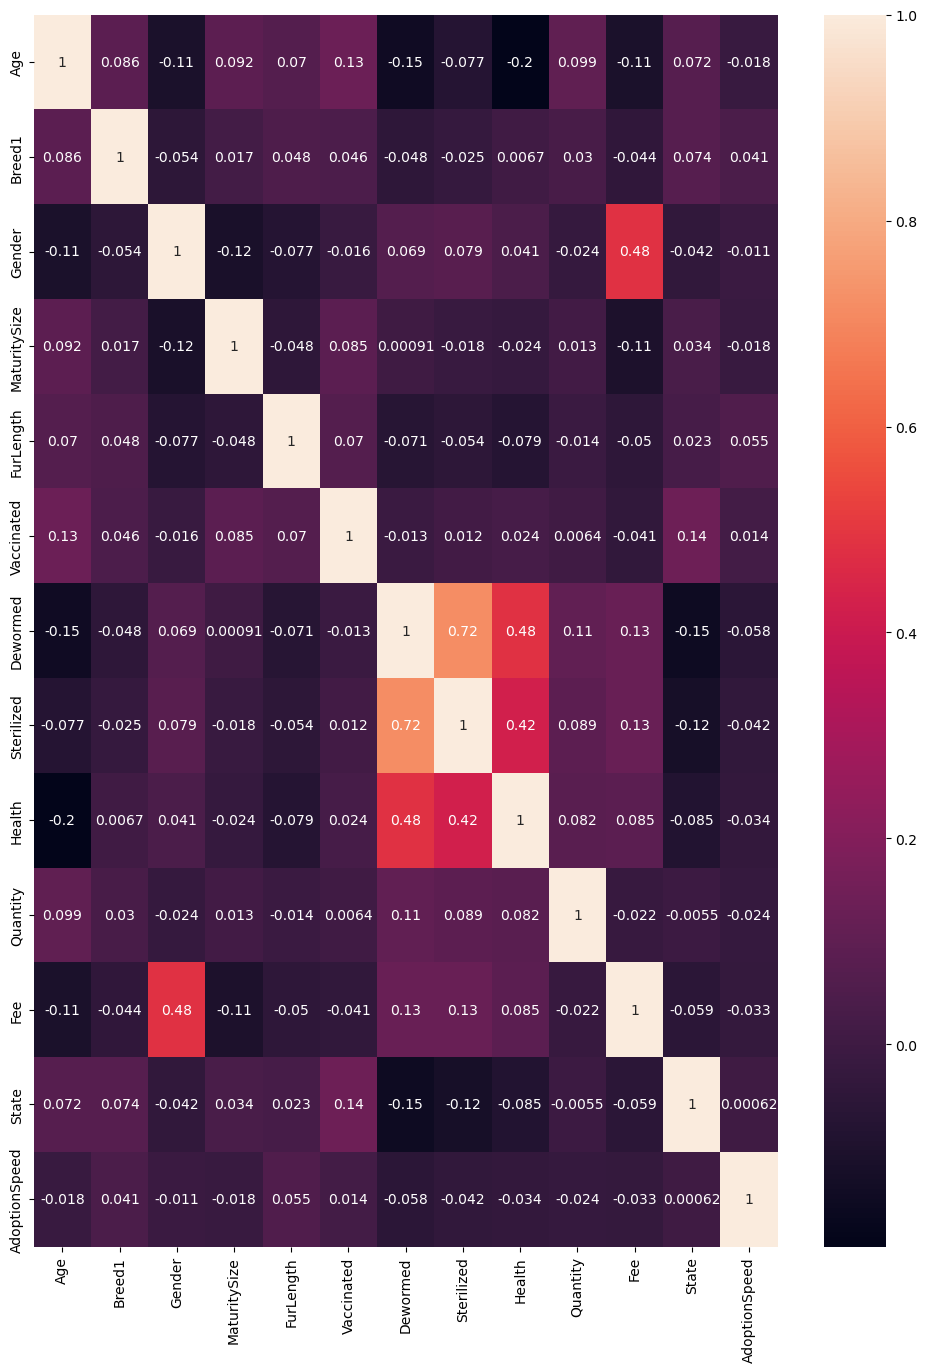

In [316]:
plt.figure(figsize=(12,16))
corr= x_test.corr()
sns.heatmap(corr, annot=True)

In [317]:
def correlation(dataset, threshold):
  col_corr=set()
  corr_matrix=dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range (i):
      if abs(corr_matrix.iloc[i,j])>threshold:
        colname=corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [318]:
corr_features=correlation(x_train, 0.62)

In [319]:
x_train.drop(corr_features, axis=1, inplace=True)
x_test.drop(corr_features, axis=1, inplace=True)

In [320]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_sc= scaler.fit_transform(x_train)
x_test_sc= scaler.transform(x_test)

In [321]:
x_train = x_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

C:\Users\Deepa\AppData\Local\Temp\ipykernel_13564\3535866935.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0.5, 1.0, 'X_train After Scaling')

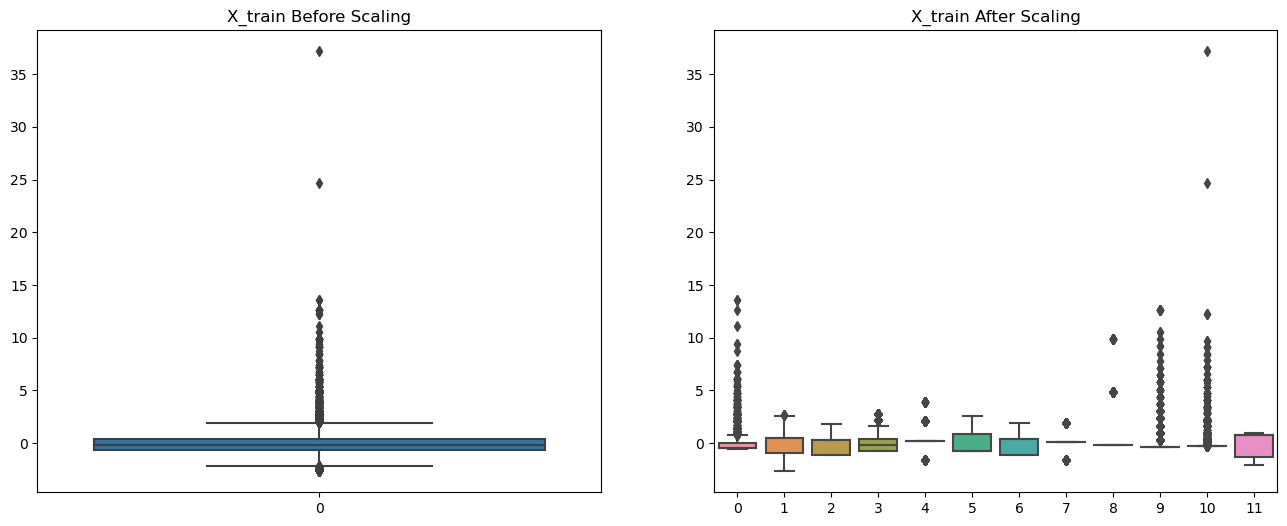

In [322]:
plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(data=x_train)
plt.title('X_train Before Scaling')
plt.subplot(1,2,2)
sns.boxplot(data=x_train_sc)
plt.title('X_train After Scaling')

In [324]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
regression=LinearRegression()
regression.fit(x_train_sc, y_train)

LinearRegression()

In [325]:
print('Intercept: \n', regression.intercept_)
print('Coefficients: \n', regression.coef_)

Intercept: 
 [2.50700777]
Coefficients: 
 [[ 0.13199892  0.03673895  0.05832149 -0.05387428  0.03637884 -0.11758924
  -0.03895956 -0.06385057  0.03577982  0.06618993  0.01064796 -0.03584981]]


In [326]:
y_pred=regression.predict(x_test_sc)
mae=mean_absolute_error(y_test, y_pred)
mse=mean_squared_error(y_test, y_pred)
r2score=r2_score(y_test, y_pred)
print("mean_squared_error", mse)
print("mean_absolute_error", mae)
print("R2_Score", r2score)

mean_squared_error 1.3467956094408566
mean_absolute_error 1.0112878480379925
R2_Score 0.03585134695161307


In [328]:
df = pd.read_csv('C:/Users/Deepa/Downloads/datatoSPSS.csv')
df

,Unnamed: 0,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed
0,0,3,156,1,1,1,1,2,2,2,1,1,100,12,2
1,1,1,57,1,1,2,2,3,3,3,1,1,0,3,0
2,2,1,104,1,2,2,2,1,1,2,1,1,0,12,3
3,3,4,104,2,1,2,1,1,1,2,1,1,150,3,2
4,4,1,104,1,1,2,1,2,2,2,1,1,0,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,14988,2,58,3,1,2,2,2,2,2,1,4,0,12,2
14989,14989,60,57,3,1,2,2,1,1,1,1,2,0,12,4
14990,14990,2,57,3,5,3,2,2,1,3,1,5,30,12,3
14991,14991,9,58,2,4,1,1,1,1,1,1,1,0,0,4


In [329]:
df.pop('Unnamed: 0')

0            0
1            1
2            2
3            3
4            4
         ...  
14988    14988
14989    14989
14990    14990
14991    14991
14992    14992
Name: Unnamed: 0, Length: 14993, dtype: int64

In [330]:
df

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed
0,3,156,1,1,1,1,2,2,2,1,1,100,12,2
1,1,57,1,1,2,2,3,3,3,1,1,0,3,0
2,1,104,1,2,2,2,1,1,2,1,1,0,12,3
3,4,104,2,1,2,1,1,1,2,1,1,150,3,2
4,1,104,1,1,2,1,2,2,2,1,1,0,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,58,3,1,2,2,2,2,2,1,4,0,12,2
14989,60,57,3,1,2,2,1,1,1,1,2,0,12,4
14990,2,57,3,5,3,2,2,1,3,1,5,30,12,3
14991,9,58,2,4,1,1,1,1,1,1,1,0,0,4


In [333]:
df['AdoptionStatus'] = ''

In [334]:
df

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed,AdoptionStatus
0,3,156,1,1,1,1,2,2,2,1,1,100,12,2,
1,1,57,1,1,2,2,3,3,3,1,1,0,3,0,
2,1,104,1,2,2,2,1,1,2,1,1,0,12,3,
3,4,104,2,1,2,1,1,1,2,1,1,150,3,2,
4,1,104,1,1,2,1,2,2,2,1,1,0,12,2,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,58,3,1,2,2,2,2,2,1,4,0,12,2,
14989,60,57,3,1,2,2,1,1,1,1,2,0,12,4,
14990,2,57,3,5,3,2,2,1,3,1,5,30,12,3,
14991,9,58,2,4,1,1,1,1,1,1,1,0,0,4,


In [336]:
df['AdoptionStatus'] = df['AdoptionSpeed'].apply(lambda x: 'Adopted' if x > 0 else 'Unadopted')

In [338]:
df

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed,AdoptionStatus
0,3,156,1,1,1,1,2,2,2,1,1,100,12,2,Adopted
1,1,57,1,1,2,2,3,3,3,1,1,0,3,0,Unadopted
2,1,104,1,2,2,2,1,1,2,1,1,0,12,3,Adopted
3,4,104,2,1,2,1,1,1,2,1,1,150,3,2,Adopted
4,1,104,1,1,2,1,2,2,2,1,1,0,12,2,Adopted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,58,3,1,2,2,2,2,2,1,4,0,12,2,Adopted
14989,60,57,3,1,2,2,1,1,1,1,2,0,12,4,Adopted
14990,2,57,3,5,3,2,2,1,3,1,5,30,12,3,Adopted
14991,9,58,2,4,1,1,1,1,1,1,1,0,0,4,Adopted


In [340]:
df.pop('AdoptionSpeed')

0        2
1        0
2        3
3        2
4        2
        ..
14988    2
14989    4
14990    3
14991    4
14992    3
Name: AdoptionSpeed, Length: 14993, dtype: int64

In [341]:
df

,Age,Breed1,Gender,Color1,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionStatus
0,3,156,1,1,1,1,2,2,2,1,1,100,12,Adopted
1,1,57,1,1,2,2,3,3,3,1,1,0,3,Unadopted
2,1,104,1,2,2,2,1,1,2,1,1,0,12,Adopted
3,4,104,2,1,2,1,1,1,2,1,1,150,3,Adopted
4,1,104,1,1,2,1,2,2,2,1,1,0,12,Adopted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,58,3,1,2,2,2,2,2,1,4,0,12,Adopted
14989,60,57,3,1,2,2,1,1,1,1,2,0,12,Adopted
14990,2,57,3,5,3,2,2,1,3,1,5,30,12,Adopted
14991,9,58,2,4,1,1,1,1,1,1,1,0,0,Adopted


In [346]:
x1 = df[['Age','Breed1','Gender','Color1','MaturitySize','FurLength', 'Vaccinated','Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State']]
y1 = df[['AdoptionStatus']]

In [359]:
from sklearn.model_selection import train_test_split

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.66, random_state = 2406)

In [360]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x1_train, y1_train)
Y_pred_dt = decision_tree.predict(x1_test)
acc_decision_tree = round(decision_tree.score(x1_train, y1_train) * 100, 2)
acc_decision_tree

99.53

[Text(0.5024038461538461, 0.9166666666666666, 'FurLength <= 2.5\ngini = 0.052\nsamples = 100.0%\nvalue = [0.973, 0.027]\nclass = Adopted'),
 Text(0.28365384615384615, 0.75, 'Breed1 <= 116.5\ngini = 0.049\nsamples = 94.5%\nvalue = [0.975, 0.025]\nclass = Adopted'),
 Text(0.15384615384615385, 0.5833333333333334, 'Breed1 <= 98.5\ngini = 0.043\nsamples = 83.9%\nvalue = [0.978, 0.022]\nclass = Adopted'),
 Text(0.07692307692307693, 0.4166666666666667, 'Breed1 <= 74.5\ngini = 0.061\nsamples = 43.1%\nvalue = [0.969, 0.031]\nclass = Adopted'),
 Text(0.038461538461538464, 0.25, 'Health <= 2.5\ngini = 0.054\nsamples = 39.9%\nvalue = [0.972, 0.028]\nclass = Adopted'),
 Text(0.019230769230769232, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.057692307692307696, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.11538461538461539, 0.25, 'MaturitySize <= 3.5\ngini = 0.147\nsamples = 3.2%\nvalue = [0.92, 0.08]\nclass = Adopted'),
 Text(0.09615384615384616, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.1

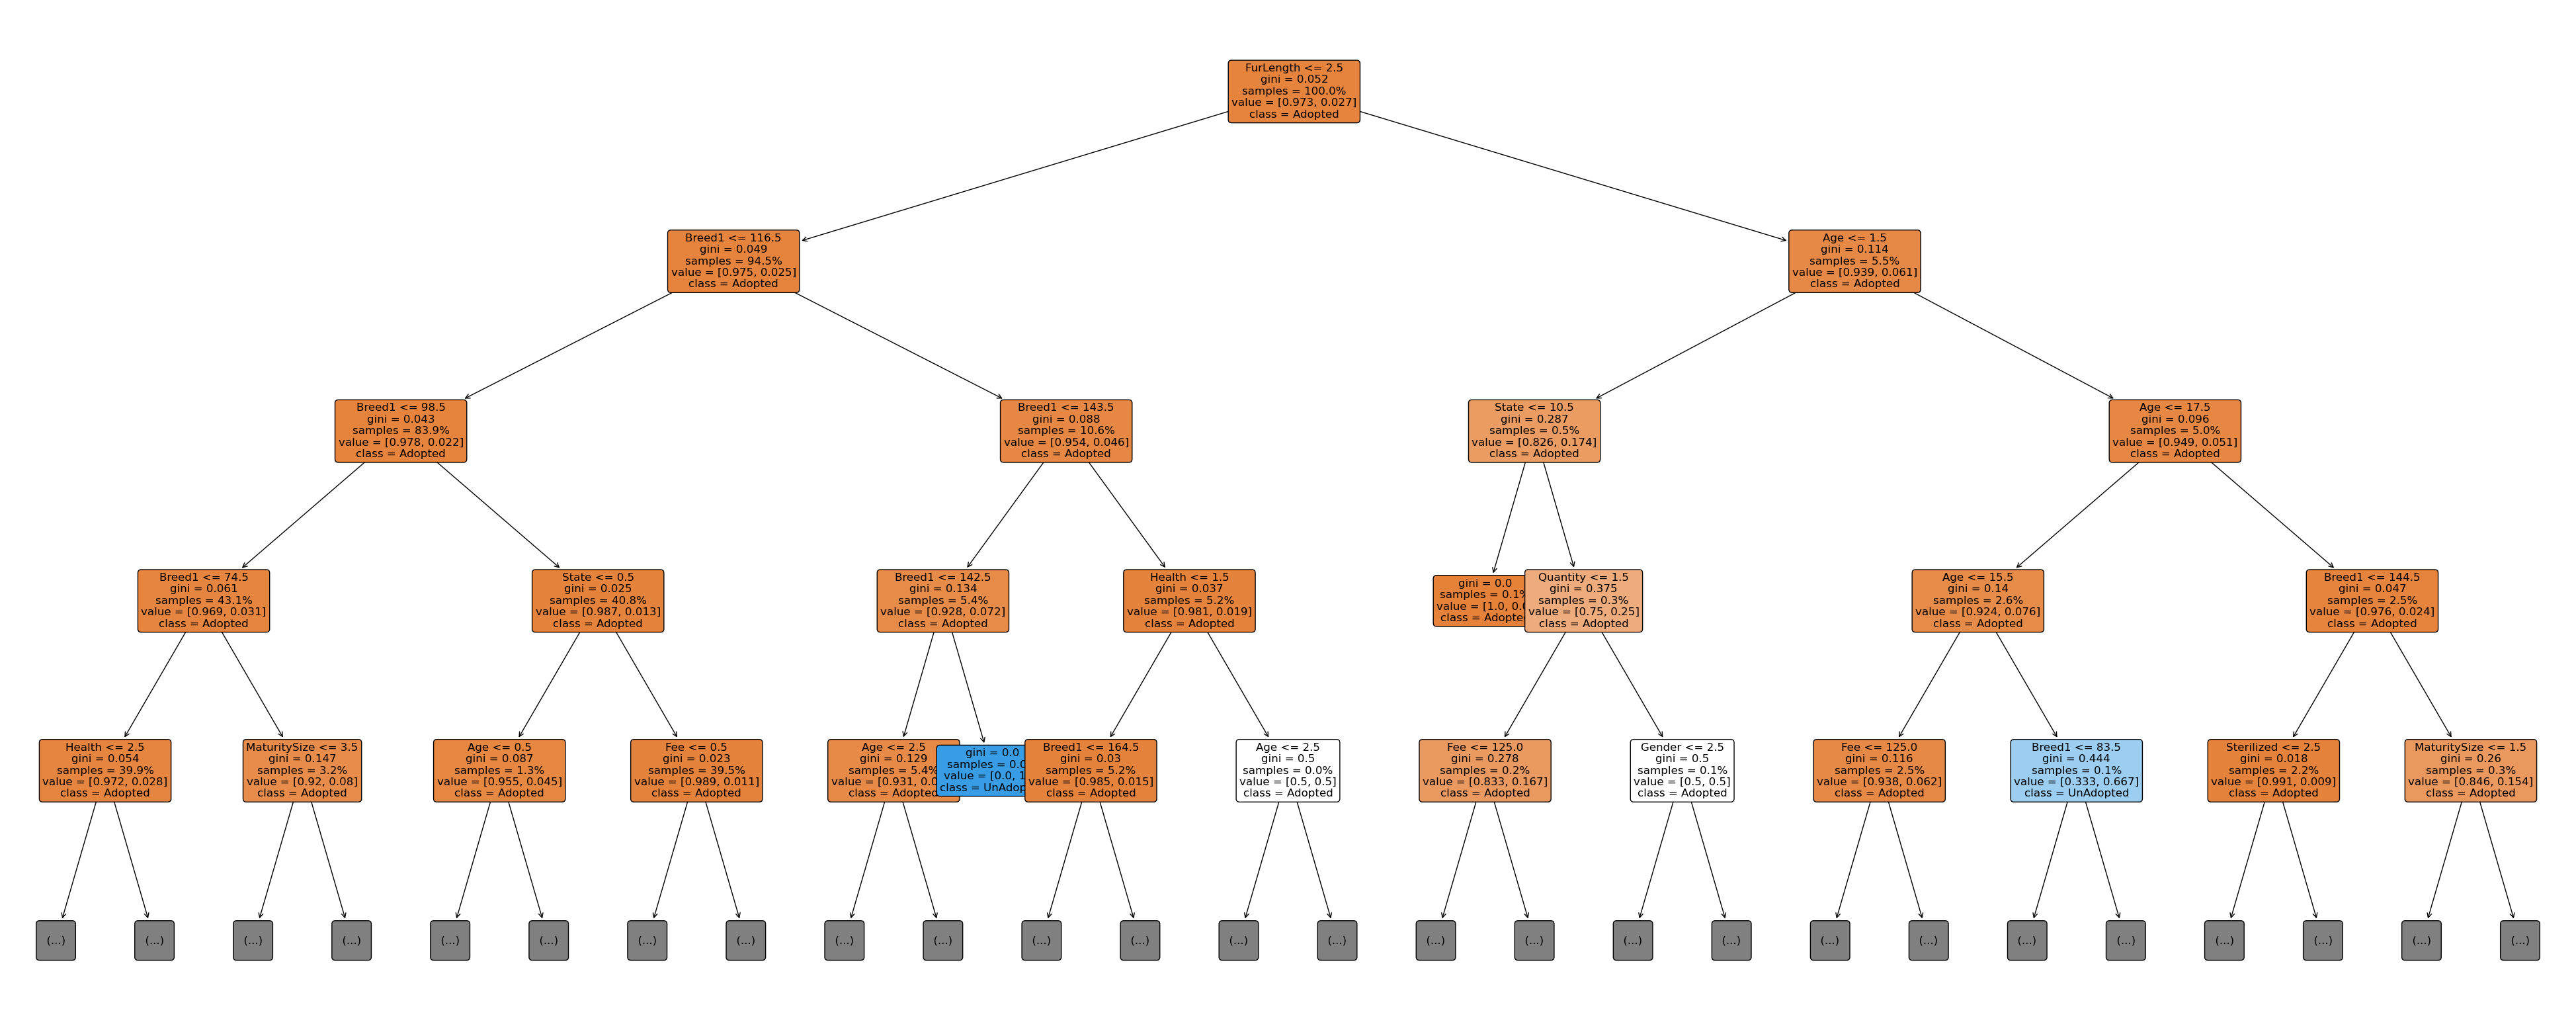

In [361]:
feature_names = ['Age','Breed1','Gender','Color1','MaturitySize','FurLength', 'Vaccinated','Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State']
class_names = ['Adopted', 'UnAdopted']
plt.figure(figsize=(50, 20))

from sklearn import tree
tree.plot_tree(decision_tree,feature_names=feature_names, class_names=class_names, filled=True,rounded=True,fontsize=12,max_depth=4,impurity=True,proportion=True)

In [362]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

In [363]:
print(classification_report(y1_test, Y_pred_dt))
print('*'*100)
pd.DataFrame(confusion_matrix(y1_test,Y_pred_dt),\
            columns=["Predicted Unadopted", "Predicted Adopted"],\
            index=["Unadopted","Adopted"])

              precision    recall  f1-score   support

     Adopted       0.97      0.97      0.97      9623
   Unadopted       0.07      0.09      0.08       273

    accuracy                           0.94      9896
   macro avg       0.52      0.53      0.53      9896
weighted avg       0.95      0.94      0.95      9896

****************************************************************************************************


,Predicted Unadopted,Predicted Adopted
Unadopted,9308,315
Adopted,248,25
